# Lab Assignment Seven: Recurrent Network Architectures

Group: Nick Benso & Benjamin Kuo

In this lab, you will select a prediction task to perform on your dataset, evaluate a recurrent architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

## Dataset Selection
Select a dataset that is text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

Dataset Link: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/input

## Preparation (3 points total)

[2 points] Define and prepare your data set. Provide details about the source of the data. Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  Also discuss your rationale for the size and nature of your vocabulary.

[0.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[0.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.
 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

df = pd.read_csv("IMDB Dataset.csv")

In [6]:
target = df["sentiment"]
X = df["review"].astype(str).to_numpy()
print(target.value_counts())
df

positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


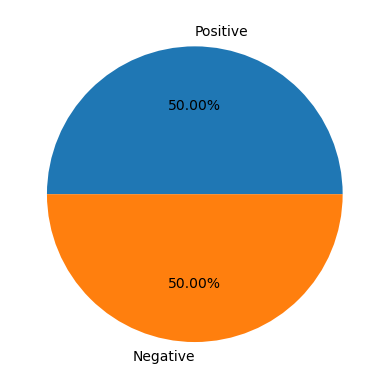

In [7]:
plt.pie(target.value_counts(),autopct="%.2f%%",labels=['Positive', 'Negative'])
plt.show()

## Modeling (6 points total)
[2 points] Investigate at least two different recurrent network architectures  Be sure to use an embedding layer . Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them. Justify your choice of parameters for each.

[1 point] Use the Glove pre-trained embedding. Provide justification of the embedding size.

[1 points] Using the best parameters and architecture from the RNN in the previous step, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

[0.5 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab.

[0.5 points] Run to convergence

[1 point]  Visualize the results of all the RNNs you trained. 

## Exceptional Work (1 points total)
You have free rein to provide additional analyses.

One idea (required for 7000 level students to do one of these options):

Research and use the ConceptNet, Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 

Another Idea (NOT required): Try to create a RNN for generating novel text. 
nd GRU). 

Alternatively, you may also choose one recurrent network and one convolutional network.